In [15]:
# %%
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, f1_score, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer
import warnings
warnings.filterwarnings('ignore')

In [16]:
# %%
def run_distributed_knn_simulation(data, n_simulations=10, n_servers=100, test_size=0.2):
    """
    Run multiple simulations of distributed KNN approach
    """
    simulation_results = []
    
    for sim in range(n_simulations):
        print(f"Running simulation {sim+1}/{n_simulations}")
        
        # 1. Split data into training and completely held-out test set
        X = data.drop(['target'], axis=1)
        y = data['target']
        
        # Hold out test data that NEVER appears in any server's training data
        X_train_full, X_test_heldout, y_train_full, y_test_heldout = train_test_split(
            X, y, test_size=test_size, random_state=sim, stratify=y
        )
        
        # 2. Generate server datasets from training data only
        def generate_server_datasets(data, n_servers=100):
            server_datasets = []
            min_samples = 500
            max_samples = 2000
            
            for _ in range(n_servers):
                sample_size = np.random.randint(min_samples, max_samples)
                start_idx = np.random.randint(0, len(data) - sample_size)
                server_data = data.iloc[start_idx:start_idx + sample_size]
                server_datasets.append(server_data)
            
            return server_datasets
        
        server_datasets = generate_server_datasets(
            pd.concat([X_train_full, y_train_full], axis=1), 
            n_servers=n_servers
        )
        
        # 3. Train models on each server (same as your original code)
        best_neighbors = []
        best_f1_scores = []
        median_neighbor_distance = []
        model_instance_list = []
        dataset_sizes = []
        
        for i, df in enumerate(server_datasets):
            params = {"n_neighbors": np.arange(3, 101, 2)}
            knn = KNeighborsClassifier()
            model = GridSearchCV(knn, params, scoring='f1_macro', cv=3, n_jobs=-1)
            
            X_server = df.drop(['target'], axis=1)
            y_server = df['target']
            
            # Split server data for validation
            X_s_train, X_s_test, y_s_train, y_s_test = train_test_split(
                X_server, y_server, test_size=0.3, random_state=42, stratify=y_server
            )
            
            model.fit(X_s_train, y_s_train)
            y_pred = model.predict(X_s_test)
            
            best_neighbors.append(model.best_params_['n_neighbors'])
            best_f1_scores.append(f1_score(y_s_test, y_pred))
            model_instance_list.append(model)
            
            # Compute median distances
            nbrs = KNeighborsClassifier(n_neighbors=model.best_params_['n_neighbors'])
            nbrs.fit(X_s_train, y_s_train)
            distances, indices = nbrs.kneighbors(X_s_train)
            distances_no_self = distances[:, 1:]
            median_neighbor_distance.append(np.median(distances_no_self))
            
            dataset_sizes.append(df.shape[0])
        
        # Create metrics dataframe
        metrics_df = pd.DataFrame({
            'optimal_k_value': best_neighbors,
            'best_f1_scores': best_f1_scores,
            'median_neighbor_distance': median_neighbor_distance,
            'model_instance': model_instance_list,
            'dataset_size': dataset_sizes
        })
        
        metrics_df = metrics_df[metrics_df['best_f1_scores'] != 0]
        
        # Calculate scoring functions
        min_median_distance = metrics_df['median_neighbor_distance'].min()
        max_median_distance = metrics_df['median_neighbor_distance'].max()
        
        def arctan_score(distance, min_d, max_d):
            return 0.5 + (np.arctan(((max_d + min_d)/2) - distance)/np.pi)
        
        def tanh_score(distance, min_d, max_d):
            return 0.5 + 0.5*(np.tanh(((max_d + min_d)/2) - distance))
        
        def sigmoid_score(distance, min_d, max_d):
            return 1 / (1 + 2*np.exp(((max_d + min_d)/2) - distance))
        
        metrics_df["arctan_score"] = metrics_df["median_neighbor_distance"].apply(
            lambda x: arctan_score(x, min_median_distance, max_median_distance)
        )
        metrics_df["tanh_score"] = metrics_df["median_neighbor_distance"].apply(
            lambda x: tanh_score(x, min_median_distance, max_median_distance)
        )
        metrics_df["sigmoid_score"] = metrics_df["median_neighbor_distance"].apply(
            lambda x: sigmoid_score(x, min_median_distance, max_median_distance)
        )
        
        # 4. Test on completely held-out data
        n_test_samples = min(500, len(X_test_heldout))  # Use reasonable test size
        test_indices = np.random.choice(
            len(X_test_heldout), size=n_test_samples, replace=False
        )
        X_test_samples = X_test_heldout.iloc[test_indices]
        y_test_true = y_test_heldout.iloc[test_indices]
        
        # Get predictions from all models
        probability_list = []
        for _, test_point in X_test_samples.iterrows():
            probabilities = []
            for _, row in metrics_df.iterrows():
                model = row['model_instance']
                prob = model.predict_proba(test_point.values.reshape(1, -1))[0]
                
                # Ensure consistent probability ordering
                full_prob = np.zeros(2)
                for i, cls in enumerate(model.classes_):
                    full_prob[int(cls)] = prob[i]
                probabilities.append(full_prob)
            probability_list.append(probabilities)
        
        probability_list = np.array(probability_list)
        
        # Calculate weighted predictions for each approach
        approach_results = {}
        
        # Approach 1: Arctan scoring
        approach_1_results = []
        for probability in probability_list:
            weighted = probability * metrics_df['arctan_score'].values.reshape(-1, 1)
            approach_1_results.append(weighted.sum(axis=0) / metrics_df['arctan_score'].sum())
        
        # Approach 2: Dataset size weighting
        approach_2_results = []
        for probability in probability_list:
            weighted = probability * metrics_df['dataset_size'].values.reshape(-1, 1)
            approach_2_results.append(weighted.sum(axis=0) / metrics_df['dataset_size'].sum())
        
        # Approach 3: Tanh scoring
        approach_3_results = []
        for probability in probability_list:
            weighted = probability * metrics_df['tanh_score'].values.reshape(-1, 1)
            approach_3_results.append(weighted.sum(axis=0) / metrics_df['tanh_score'].sum())
        # Approach 4: Sigmoid scoring
        approach_4_results = []
        for probability in probability_list:
            weighted = probability * metrics_df['sigmoid_score'].values.reshape(-1, 1)
            approach_4_results.append(weighted.sum(axis=0) / metrics_df['sigmoid_score'].sum())
        
        # Convert to predictions
        approach_1_preds = np.array([np.argmax(p) for p in approach_1_results])
        approach_2_preds = np.array([np.argmax(p) for p in approach_2_results])
        approach_3_preds = np.array([np.argmax(p) for p in approach_3_results])
        approach_4_preds = np.array([np.argmax(p) for p in approach_4_results])
        
        # Calculate metrics
        sim_result = {
            'simulation': sim,
            'approach_1_f1': f1_score(y_test_true, approach_1_preds),
            'approach_2_f1': f1_score(y_test_true, approach_2_preds),
            'approach_3_f1': f1_score(y_test_true, approach_3_preds),
            'approach_4_f1': f1_score(y_test_true, approach_4_preds),
            'approach_1_acc': accuracy_score(y_test_true, approach_1_preds),
            'approach_2_acc': accuracy_score(y_test_true, approach_2_preds),
            'approach_3_acc': accuracy_score(y_test_true, approach_3_preds),
            'approach_4_acc': accuracy_score(y_test_true, approach_4_preds),
            'n_servers': len(metrics_df),
            'avg_dataset_size': metrics_df['dataset_size'].mean()
        }
        
        simulation_results.append(sim_result)
    
    return pd.DataFrame(simulation_results)

In [17]:
# %%
# Load your data
data = pd.read_csv('./data/beta-2-3.csv')

# Run multiple simulations
results_df = run_distributed_knn_simulation(data, n_simulations=20, n_servers=100)

Running simulation 1/20
Running simulation 2/20
Running simulation 3/20
Running simulation 4/20
Running simulation 5/20
Running simulation 6/20
Running simulation 7/20
Running simulation 8/20
Running simulation 9/20
Running simulation 10/20
Running simulation 11/20
Running simulation 12/20
Running simulation 13/20
Running simulation 14/20
Running simulation 15/20
Running simulation 16/20
Running simulation 17/20
Running simulation 18/20
Running simulation 19/20
Running simulation 20/20


In [18]:
# Find the best KNN on overall data
X = data.drop(['target'], axis=1)
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3, 
                                                    random_state=42, 
                                                    stratify=y)
params = {"n_neighbors": np.arange(3, 101, 2)}
knn = KNeighborsClassifier()
model = GridSearchCV(knn, params, scoring='f1_macro', cv=3, n_jobs=-1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(f"Best K: {model.best_params_['n_neighbors']}")
print(f"Best F1 Score: {f1_score(y_test, y_pred)}")

benchmark_f1 = f1_score(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.96      0.99      0.97      1620
           1       0.98      0.93      0.96      1080

    accuracy                           0.97      2700
   macro avg       0.97      0.96      0.96      2700
weighted avg       0.97      0.97      0.97      2700

Best K: 21
Best F1 Score: 0.9554079696394687


In [19]:
# %%
# Analyze results
print("Simulation Results Summary:")
print("=" * 50)
print(f"Number of simulations: {len(results_df)}")
print(f"Average F1 Scores:")
print(f"Approach 1 (Arctan): {results_df['approach_1_f1'].mean():.4f} ± {results_df['approach_1_f1'].std():.4f}")
print(f"Approach 2 (Size):   {results_df['approach_2_f1'].mean():.4f} ± {results_df['approach_2_f1'].std():.4f}")
print(f"Approach 3 (Tanh):   {results_df['approach_3_f1'].mean():.4f} ± {results_df['approach_3_f1'].std():.4f}")
print(f"Approach 4 (Sigmoid):   {results_df['approach_4_f1'].mean():.4f} ± {results_df['approach_4_f1'].std():.4f}")


Simulation Results Summary:
Number of simulations: 20
Average F1 Scores:
Approach 1 (Arctan): 0.9422 ± 0.0135
Approach 2 (Size):   0.9442 ± 0.0127
Approach 3 (Tanh):   0.9422 ± 0.0135
Approach 4 (Sigmoid):   0.9421 ± 0.0134


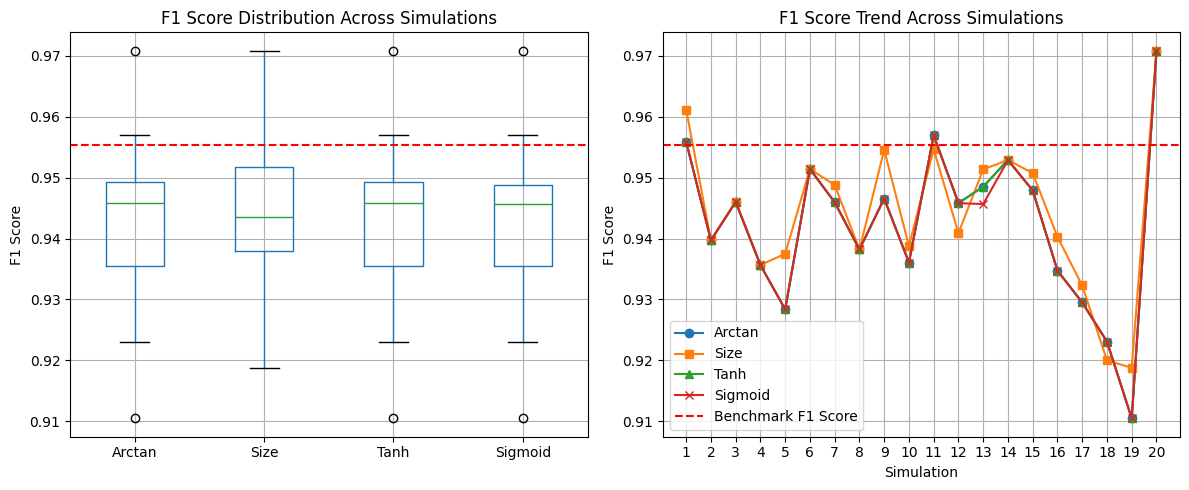

In [22]:
# %%
# Visualization
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
results_df[['approach_1_f1', 'approach_2_f1', 'approach_3_f1', 'approach_4_f1']].boxplot()
plt.title('F1 Score Distribution Across Simulations')
plt.ylabel('F1 Score')
plt.axhline(y=benchmark_f1, color='r', linestyle='--', label='Benchmark F1 Score')
plt.xticks([1, 2, 3, 4], ['Arctan', 'Size', 'Tanh', 'Sigmoid'])

plt.subplot(1, 2, 2)
plt.plot(results_df['approach_1_f1'], label='Arctan', marker='o')
plt.plot(results_df['approach_2_f1'], label='Size', marker='s')
plt.plot(results_df['approach_3_f1'], label='Tanh', marker='^')
plt.plot(results_df['approach_4_f1'], label='Sigmoid', marker='x')
plt.axhline(y=benchmark_f1, color='r', linestyle='--', label='Benchmark F1 Score')
plt.xticks(np.arange(len(results_df)), np.arange(1, len(results_df)+1))
plt.xlabel('Simulation')
plt.ylabel('F1 Score')
plt.title('F1 Score Trend Across Simulations')
plt.legend()
plt.grid(True)

plt.savefig('./plots/f1_score_trends_std_normal.png')

plt.tight_layout()
plt.show()


In [21]:
# %%
# Statistical significance testing
from scipy.stats import ttest_rel

# Pairwise t-tests
t_stat_1_2, p_val_1_2 = ttest_rel(results_df['approach_1_f1'], results_df['approach_2_f1'])
t_stat_1_3, p_val_1_3 = ttest_rel(results_df['approach_1_f1'], results_df['approach_3_f1'])
t_stat_2_3, p_val_2_3 = ttest_rel(results_df['approach_2_f1'], results_df['approach_3_f1'])
t_stat_2_4, p_val_2_4 = ttest_rel(results_df['approach_2_f1'], results_df['approach_4_f1'])
t_stat_3_4, p_val_3_4 = ttest_rel(results_df['approach_3_f1'], results_df['approach_4_f1'])
t_stat_1_4, p_val_1_4 = ttest_rel(results_df['approach_1_f1'], results_df['approach_4_f1'])

print("\nStatistical Significance (paired t-tests):")
print(f"Arctan vs Size: p-value = {p_val_1_2:.4f}")
print(f"Arctan vs Tanh: p-value = {p_val_1_3:.4f}")
print(f"Size vs Tanh: p-value = {p_val_2_3:.4f}")
print(f"Size vs Sigmoid: p-value = {p_val_2_4:.4f}")
print(f"Tanh vs Sigmoid: p-value = {p_val_3_4:.4f}")
print(f"Arctan vs Sigmoid: p-value = {p_val_1_4:.4f}")


Statistical Significance (paired t-tests):
Arctan vs Size: p-value = 0.0292
Arctan vs Tanh: p-value = nan
Size vs Tanh: p-value = 0.0292
Size vs Sigmoid: p-value = 0.0231
Tanh vs Sigmoid: p-value = 0.3299
Arctan vs Sigmoid: p-value = 0.3299
